# 通过手工标签做相机标定

### 模块导入 

In [11]:
import xml.etree.cElementTree as et 
import os, glob, shutil
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import cv2

导入所有的xml，按照预定好的行列数，生成世界坐标系

In [9]:
def get_dots_by_xml(xml_path):
    tree = et.parse(xml_path)
    root = tree.getroot()
    dots = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        bbox = [int(bbox.find(tag).text) for tag in ['xmin', 'ymin', 'xmax', 'ymax']]
        dot = bbox[:2]
        dots.append(dot)
    return np.array(dots)

def generate_objpoints_dict(xml_dir):
    xmllist = glob.glob(os.path.join(xml_dir, '*.xml'))
    dot_dict = {}
    for xml in xmllist:
        dots = get_dots_by_xml(xml)
        dot_dict[xml] = dots
    return dot_dict

def reorganize_dots(dot_dict, x_num, y_num):
    for k, d in dot_dict.items():
        assert x_num * y_num == len(d)
        xs, ys = d.T
        d = d[xs.argsort()]
        argsort = np.array([])
        for i in range(x_num):
            cluster = d[:,1][y_num * i:y_num * (i + 1)]
            argsort = np.append(argsort, cluster.argsort() + (i * y_num))
        dot_dict[k] = d[argsort.astype(np.uint32)].astype(np.float32)

    return dot_dict

def generate_world_points(x_num, y_num):
    xs, ys = np.meshgrid(np.arange(y_num), np.arange(x_num))
    world_points = np.array([x.ravel() for x in [ys, xs, np.zeros(xs.shape)]]).T
    return world_points.astype(np.float32)

def calibration(dot_dict, x_num, y_num, img_size, pkl_savepath = '.'):
    imgpoints = [v.astype(np.float32) for v in dot_dict.values()]
    objpoints = [generate_world_points(x_num, y_num) for v in dot_dict.values()]
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump(dist_pickle, open(os.path.join(pkl_savepath, "dist_pickle.pkl"), "wb" ))
    
def get_img_size_by_xml(xml_dir):
    hs, ws = [], []
    for xml in glob.glob(os.path.join(xml_dir, '*.xml')):
        tree = et.parse(xml)
        root = tree.getroot()
        h = int(root.find('size').find('height').text)
        w = int(root.find('size').find('width').text)
        hs.append(h)
        ws.append(w)
    assert h == np.mean(hs), 'xmls are from different size of images'
    return h, w

def calibrate_camera(xml_dir, x_num, y_num, pkl_savepath = '.'):
    img_size = get_img_size_by_xml(xml_dir)
    dot_dict = generate_objpoints_dict(xml_dir)
    new_dots = reorganize_dots(dot_dict, x_num, y_num)
    
    calibration(dot_dict, x_num, y_num, img_size, pkl_savepath)
    print('finish calibration! pkl saved at %s' % os.path.abspath(pkl_savepath))

if __name__ == '__main__':
    path = r'./xmls'
    calibrate_camera(path, 5, 10)

finish calibration! pkl saved at /data/el-train/WG


通过找到的点，训练相机参数

Text(0.5,1,'Undistorted Image')

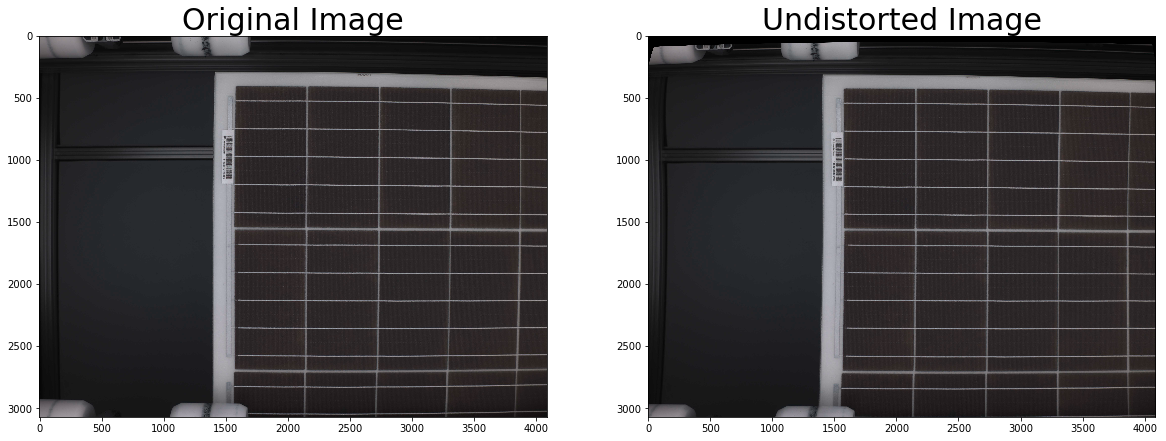

In [12]:
def undistort(img, pkl_file):
    global mtx, dist
    try:
        mtx, dist
    except:
        
        pkl = pickle.load(open(pkl_file, 'rb'))
        mtx = pkl['mtx']
        dist = pkl['dist']
    
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

# Test undistortion on an image
img = cv2.imread('./data/119_A1.jpg')
img_size = img.shape[:2]
dst = undistort(img, './dist_pickle.pkl')
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [13]:
import os, glob, shutil
path = r'./data'
for i in range(4):
#     os.makedirs(r'./cam%i' % (i+1))
    for f in glob.glob(r'./data/*%i.jpg' % (i+1)):
        shutil.copy(f, r'./cam%i/%s' % (i+1, os.path.basename(f)))

In [14]:
!zip cam1.zip ./cam1/* 

  adding: cam1/11902110173301_2_A1.jpg (deflated 12%)
  adding: cam1/11902110173301_2_B1.jpg (deflated 10%)
  adding: cam1/11902110173301_2_C1.jpg (deflated 12%)
  adding: cam1/11902110173301_3_A1.jpg (deflated 12%)
  adding: cam1/11902110173301_3_B1.jpg (deflated 10%)
  adding: cam1/11902110173301_3_C1.jpg (deflated 11%)
  adding: cam1/11902110173359_1.jpg (deflated 10%)
  adding: cam1/11902110173359_1_A1.jpg (deflated 18%)
  adding: cam1/11902110173359_1_B1.jpg (deflated 18%)
  adding: cam1/11902110173359_1_C1.jpg (deflated 20%)
  adding: cam1/11902110173359_A1.jpg (deflated 18%)
  adding: cam1/11902110173359_B1.jpg (deflated 18%)
  adding: cam1/11902110173359_C1.jpg (deflated 20%)
  adding: cam1/11902110173599_1.jpg (deflated 12%)
  adding: cam1/11902110173599_1_A1.jpg (deflated 22%)
  adding: cam1/11902110173599_1_B1.jpg (deflated 23%)
  adding: cam1/11902110173599_1_C1.jpg (deflated 24%)
  adding: cam1/119_A1.jpg (deflated 20%)
  adding: cam1/119_B1.jpg (deflated 19%)
  adding: ca

In [ ]:
!zip cam1.zip ./cam2/* 
!zip cam1.zip ./cam3/* 
!zip cam1.zip ./cam4/* 